In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plot
import seaborn as sns
import pandas as pd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

/home/jaspreet/anaconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [2]:
batch_size = 32

In [3]:
# Define the transformations to apply to the data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize( mean=(0.1307,),std= (0.3081,))])

# Download the MNIST dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

# Split the trainset into train and validation sets
trainset, valset = torch.utils.data.random_split(trainset, [50000, 10000])

# Create data loaders for the train, validation, and test sets
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=os.cpu_count())
val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                        shuffle=False, num_workers=os.cpu_count())
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=os.cpu_count(), drop_last=True)

In [4]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, latent_dim)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 256)
        self.fc2 = nn.Linear(256, 64 * 7 * 7)
        self.conv1 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1)
        self.conv2 = nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = x.view(-1, 64, 7, 7)
        x = F.relu(self.conv1(x))
        x = torch.sigmoid(self.conv2(x))
        return x

class BetaVAE(nn.Module):
    def __init__(self, latent_dim, beta):
        super(BetaVAE, self).__init__()
        self.latent_dim = latent_dim
        self.beta = beta
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
        self.fc1 = nn.Linear(self.latent_dim, self.latent_dim)
        self.fc2 = nn.Linear(self.latent_dim, self.latent_dim)
        
    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mean + eps * std
        return z
        
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar, z
    
    def encode(self, x):
        x = self.encoder(x)
        mean = self.fc1(x)
        logvar = self.fc2(x)
        return mean, logvar
    
    def decode(self, z):
        x = self.decoder(z)
        return x
    
    def loss_function(self, recon_x, x, mu, logvar):
        recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
        kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon_loss + self.beta * kl_divergence
        return loss

In [5]:
betas = [10, 20]
lr = 2e-4
latent_dim = 32

In [6]:
def plot_latent_dimention(z, y, betas):
    """Summarize results for different beta values using scatterplot

    Args:
        z (_type_): latent representation's dimentionality reduced vector
        y (_type_): label of the data point
        betas (_type_): beta values used in expreiments . eg 10 , 20
    """
    fig, axs = plot.subplots(ncols=2, figsize=(15, 6))
    for idx, beta in enumerate(betas):
        df = pd.DataFrame()
        df["y"] = y[idx]
        df["comp-1"] = z[idx][:, 0]
        df["comp-2"] = z[idx][:, 1]
        
        sns.scatterplot(x="comp-1", y="comp-2", hue=y[idx].tolist(),
                        palette=sns.color_palette("hls", 10),
                        data=df, ax=axs[idx]).set(title=f"MNIST data T-SNE projection with beta: {beta}")


In [7]:
best_loss = np.inf
patience_count = 0
epochs = 50
patience = 5

def train(model, train_loader, val_loader, optimizer):
    """Train and validate a model. Early stopping after given patience

    Args:
        model (_type_): _description_
        train_loader (_type_): train data loader
        val_loader (_type_): validation data loader for early stopping
        optimizer (_type_): adam or sgd
    """
    patience_count = patience
    best_loss = np.inf
    for epoch in range(epochs):
        model.train()
        running_loss_train = 0.0
        running_loss_val = 0.0
        val_loss = 0.0
        for batch_idx, (data, labels) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_x, mu, logvar, z = model(data)
            loss = model.loss_function(recon_x= recon_x, x= data,mu= mu, logvar= logvar)
            running_loss_train += loss.item()
            loss.backward()
            optimizer.step()
        train_loss = np.mean(running_loss_train)
        print('Epoch: {} \t Training Loss: {:.3f}'.format(epoch+1, train_loss))
        model.eval()
        with torch.no_grad():
            for batch_idx, (data, labels) in enumerate(val_loader):
                data = data.to(device)
                recon_x, mu, logvar, z = model(data)
                loss = model.loss_function(recon_x= recon_x, x= data,mu= mu, logvar= logvar)
                running_loss_val += loss.item()
            val_loss = np.mean(running_loss_val)
        if val_loss < best_loss:
            print('Epoch: {} \t Validation Loss decreased: {:.3f} --> {:.3f}'.format(epoch+1, best_loss, val_loss))
            best_loss = val_loss
            patience_count = patience
        else:
            patience_count -= 1
        if patience_count == 0:
            print('No improvement for Epoch: {} \t Early Stopping...'.format(patience))
            break

def test(model, test_loader, optimizer):
    """Test a give model without calculating gradients for backward pass

    Args:
        model (_type_): Model 
        test_loader (_type_): dataloader for testing 
        optimizer (_type_): adam or sgd

    Returns:
        _type_: _description_
    """
    patience_count = patience
    best_loss = np.inf
    model.eval()
    running_loss_test = 0.0
    latent_dimentions = []
    data_labels = []
    with torch.no_grad():
        for batch_idx, (data, labels) in enumerate(test_loader):
            data = data.to(device)
            recon_x, mu, logvar, z = model(data)
            loss = model.loss_function(recon_x= recon_x, x= data,mu= mu, logvar= logvar)
            latent_dimentions.append(z)
            data_labels.append(labels)
            running_loss_test += loss.item()
        test_loss = np.mean(running_loss_test)
        print('Testing Loss: {:.3f}'.format(test_loss))
    return torch.cat(latent_dimentions, dim=0), torch.cat(data_labels, dim=0)
    

In [8]:
labels = []
output = []
models = []
optimizers = []
for beta in betas:
    print(f"Training started with beta: {beta}")
    model = BetaVAE(latent_dim=latent_dim, beta=beta).to(device=device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train(model= model, train_loader=train_loader, val_loader=val_loader, optimizer= optimizer)
    torch.save(model.state_dict(), f'Beta({beta})VAE.pt')
    x, y = test(model= model, optimizer= optimizer,test_loader=test_loader)

    labels.append(y)
    
    ## Dimentionality reduction using TSNE
    tsne = TSNE(n_components=2, verbose=1)
    z = tsne.fit_transform(x.cpu())
    output.append(z)
    models.append(model)
    optimizers.append(optimizers)


Training started with beta: 10
Epoch: 1 	 Training Loss: -1041157111.916
Epoch: 1 	 Validation Loss decreased: inf --> -294051547.219
Epoch: 2 	 Training Loss: -1582488649.875
Epoch: 2 	 Validation Loss decreased: -294051547.219 --> -331146851.062
Epoch: 3 	 Training Loss: -1712754939.375
Epoch: 3 	 Validation Loss decreased: -331146851.062 --> -348799852.500
Epoch: 4 	 Training Loss: -1778045531.875
Epoch: 4 	 Validation Loss decreased: -348799852.500 --> -358950802.500
Epoch: 5 	 Training Loss: -1813887859.438
Epoch: 5 	 Validation Loss decreased: -358950802.500 --> -365394807.250
Epoch: 6 	 Training Loss: -1837873211.188
Epoch: 6 	 Validation Loss decreased: -365394807.250 --> -368112906.062
Epoch: 7 	 Training Loss: -1856104143.750
Epoch: 7 	 Validation Loss decreased: -368112906.062 --> -370987925.625
Epoch: 8 	 Training Loss: -1870405541.062
Epoch: 8 	 Validation Loss decreased: -370987925.625 --> -373192855.375
Epoch: 9 	 Training Loss: -1881152454.688
Epoch: 9 	 Validation Loss

/home/jaspreet/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/jaspreet/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 9984 samples in 2.198s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9984
[t-SNE] Computed conditional probabilities for sample 2000 / 9984
[t-SNE] Computed conditional probabilities for sample 3000 / 9984
[t-SNE] Computed conditional probabilities for sample 4000 / 9984
[t-SNE] Computed conditional probabilities for sample 5000 / 9984
[t-SNE] Computed conditional probabilities for sample 6000 / 9984
[t-SNE] Computed conditional probabilities for sample 7000 / 9984
[t-SNE] Computed conditional probabilities for sample 8000 / 9984
[t-SNE] Computed conditional probabilities for sample 9000 / 9984
[t-SNE] Computed conditional probabilities for sample 9984 / 9984
[t-SNE] Mean sigma: 1.639332
[t-SNE] KL divergence after 50 iterations with early exaggeration: 95.860382
[t-SNE] KL divergence after 1000 iterations: 2.995858
Training started with beta: 20
Epoch: 1 	 Training Loss: -978984414.039
Epoch: 1 	 Validation Loss decreased: inf --> -2829

/home/jaspreet/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/jaspreet/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 9984 samples in 2.106s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9984
[t-SNE] Computed conditional probabilities for sample 2000 / 9984
[t-SNE] Computed conditional probabilities for sample 3000 / 9984
[t-SNE] Computed conditional probabilities for sample 4000 / 9984
[t-SNE] Computed conditional probabilities for sample 5000 / 9984
[t-SNE] Computed conditional probabilities for sample 6000 / 9984
[t-SNE] Computed conditional probabilities for sample 7000 / 9984
[t-SNE] Computed conditional probabilities for sample 8000 / 9984
[t-SNE] Computed conditional probabilities for sample 9000 / 9984
[t-SNE] Computed conditional probabilities for sample 9984 / 9984
[t-SNE] Mean sigma: 1.608038
[t-SNE] KL divergence after 50 iterations with early exaggeration: 95.749207
[t-SNE] KL divergence after 1000 iterations: 3.448803


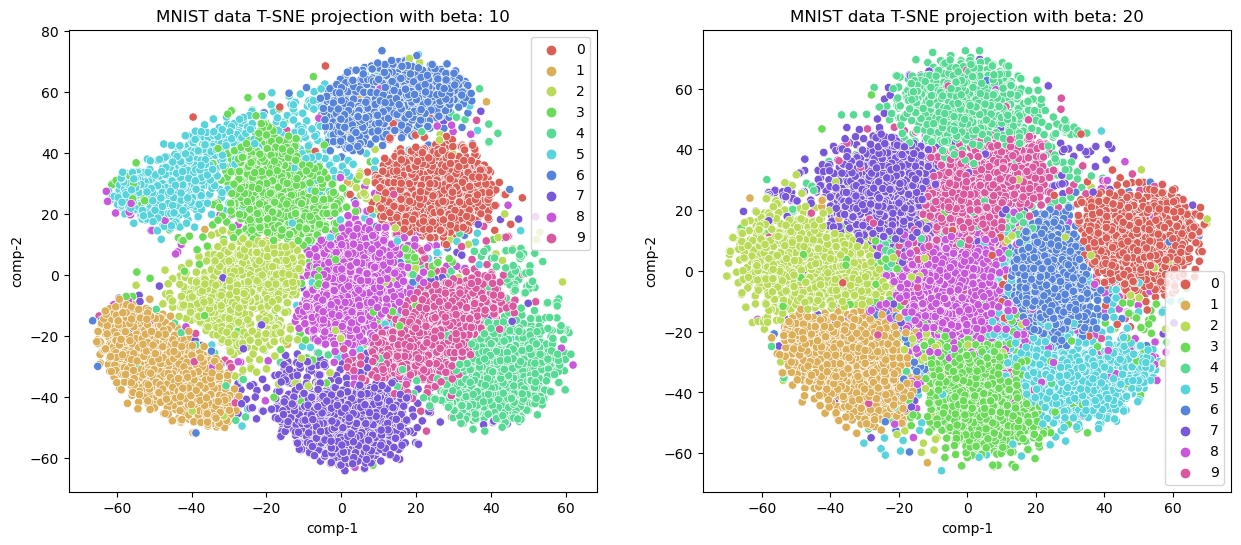

In [9]:
plot_latent_dimention(z=output,y=labels, betas= betas)

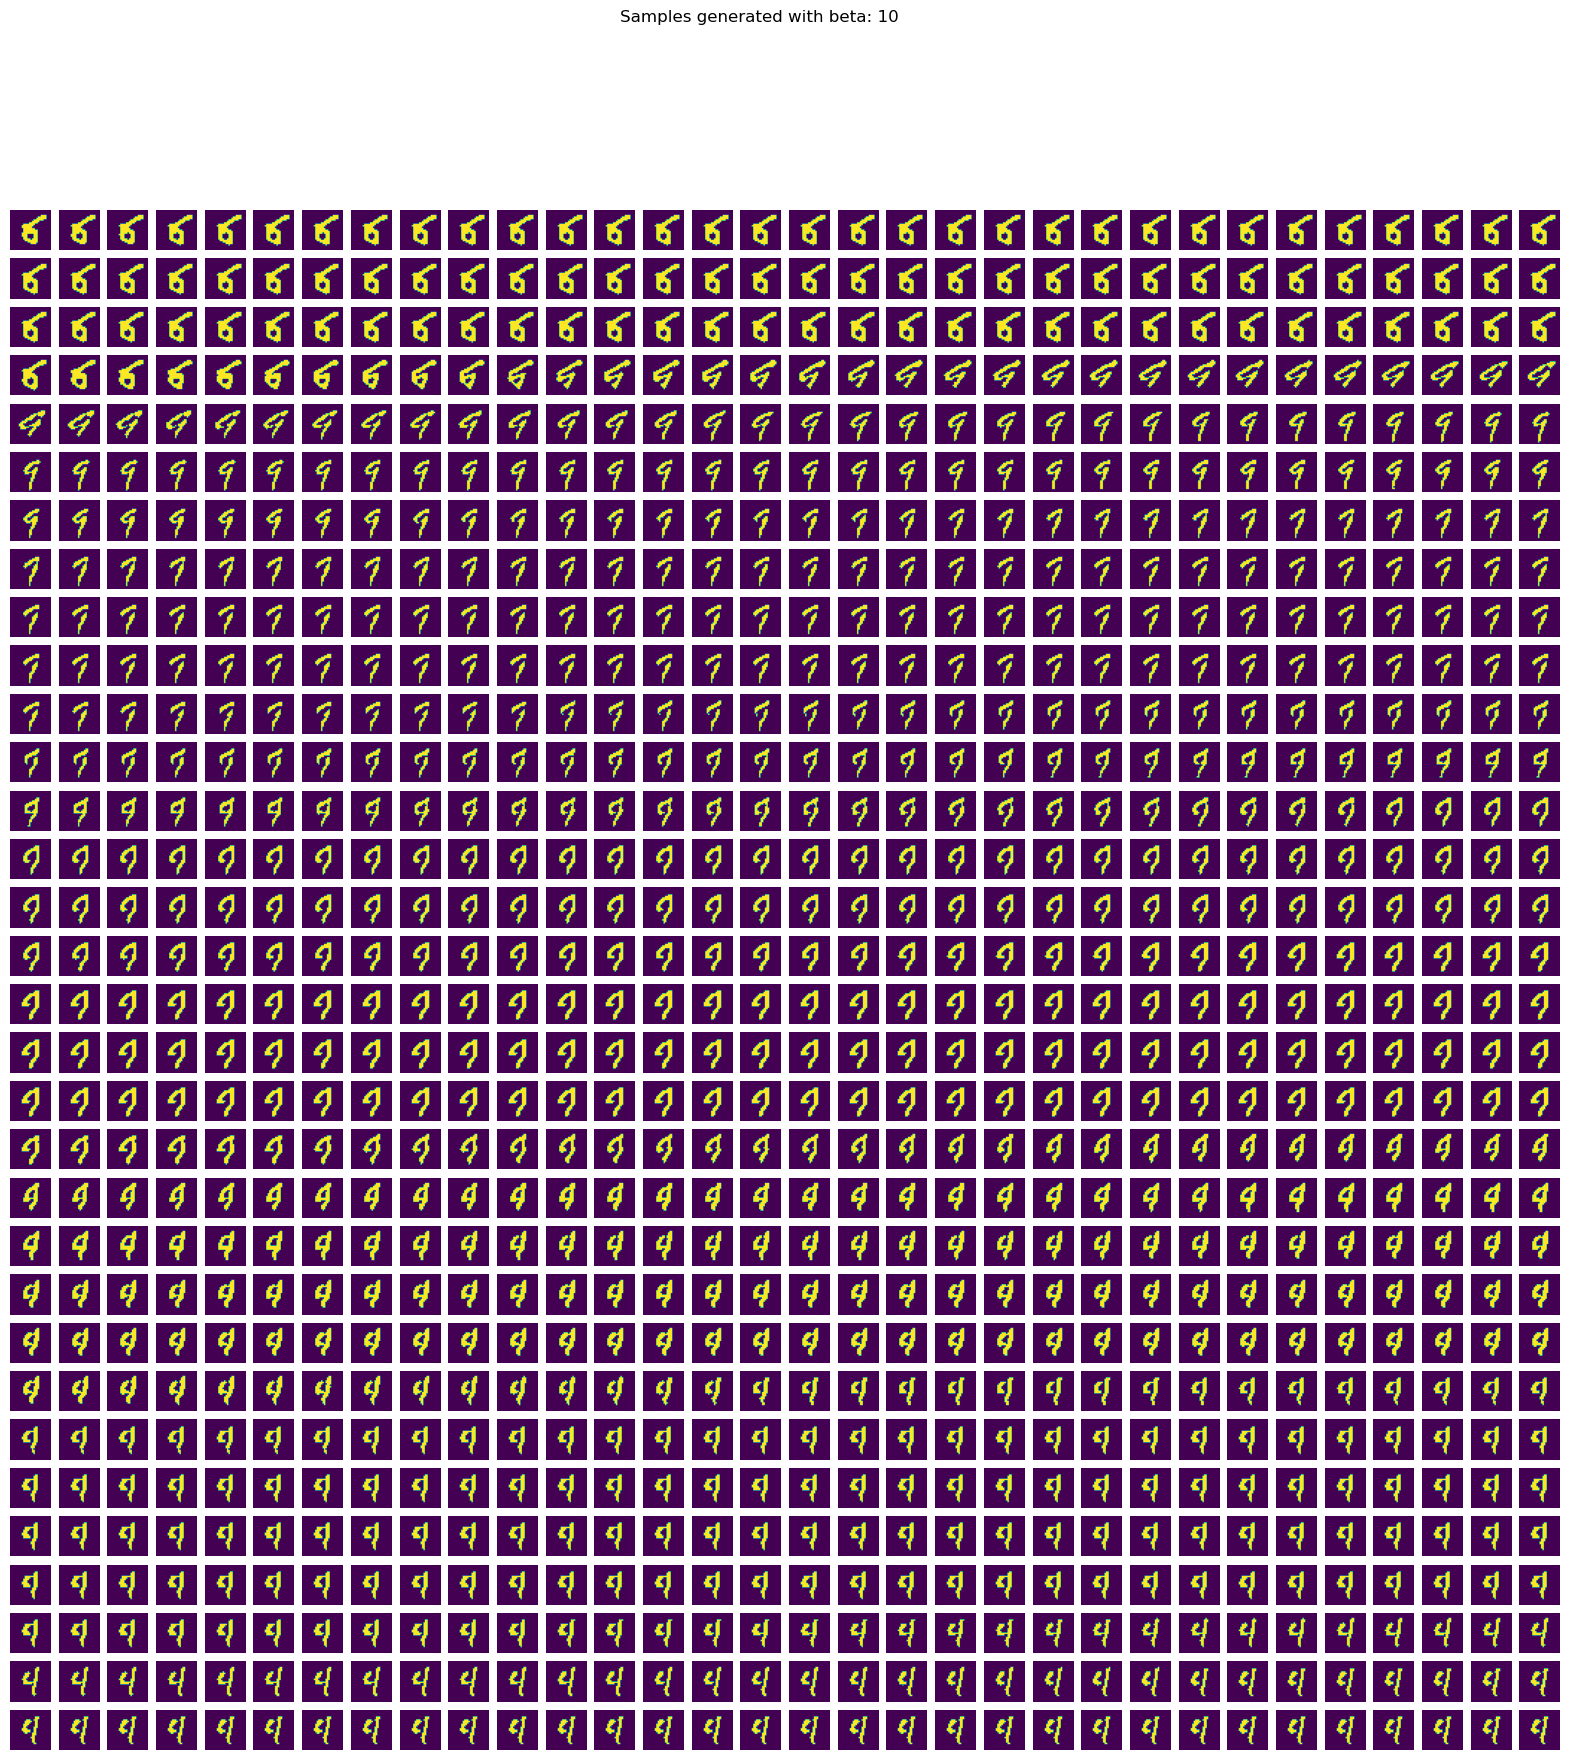

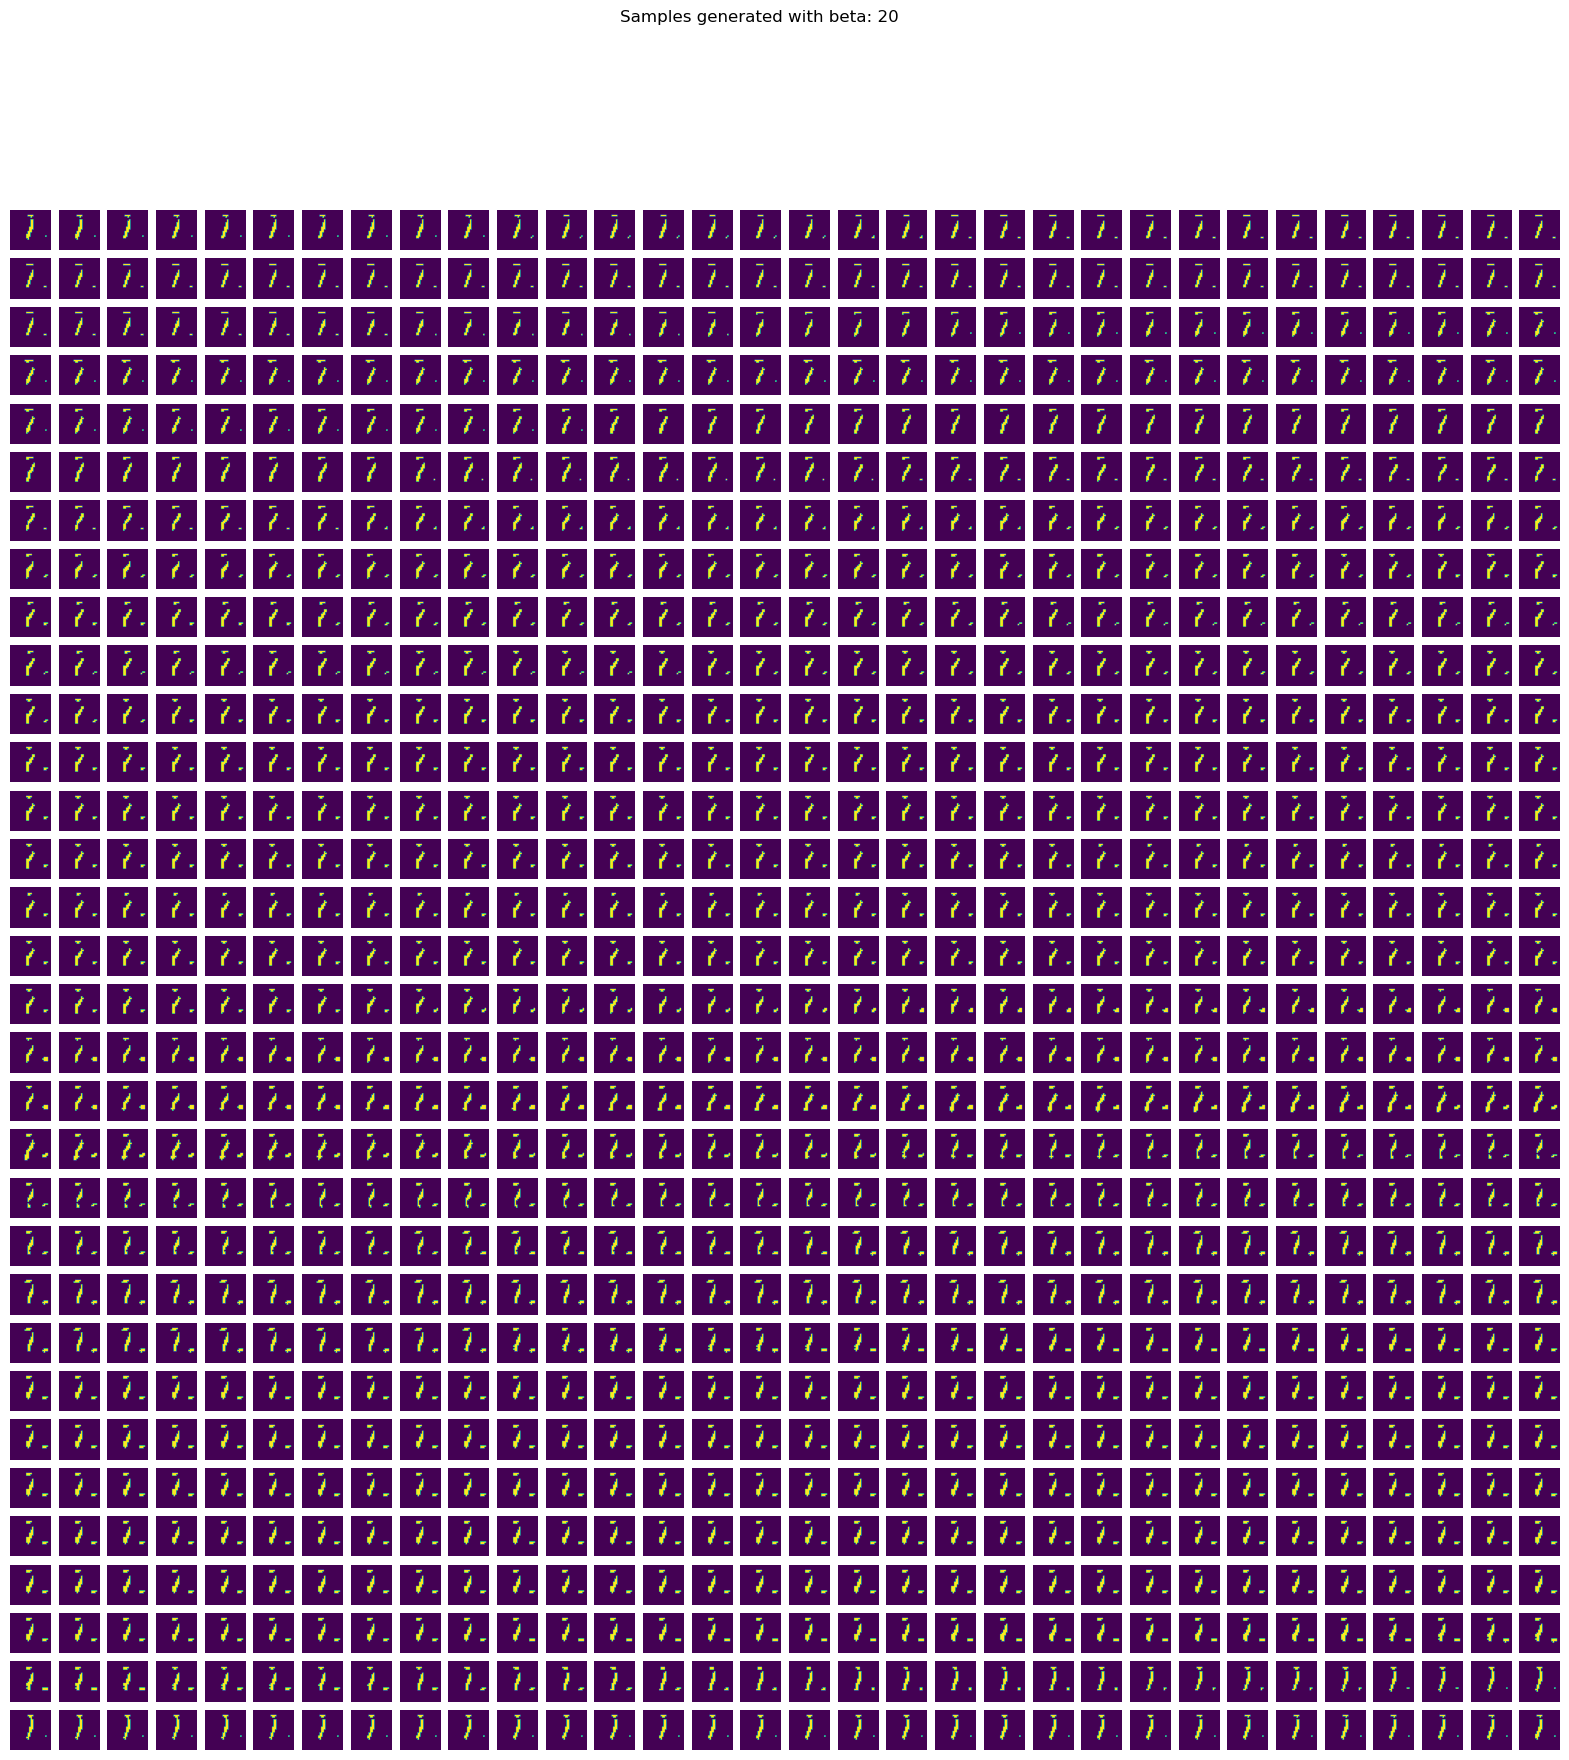

In [14]:
# Sample a random latent vector
z = torch.normal(mean=0, std=1, size=(1, latent_dim)).to(device=device)

for idx, beta in enumerate(betas):
    # Traverse latent space
    num_steps = latent_dim
    delta = 40
    generated_samples = []
    for dim in range(latent_dim):

        original = z[0, dim]
        for i in range(num_steps):
            # Change the i-th dimension of z by delta
            z[0, dim] += delta

            # Generate image from the modified latent vector
            with torch.no_grad():
                generated = models[idx].decode(z)
                generated_samples.append(
                    generated[0].permute(1, 2, 0).cpu().numpy())
        z[0, dim] = original

    # Plot generated samples
    fig, axs = plot.subplots(
        nrows=latent_dim, ncols=latent_dim, figsize=(20, 20))
    for i in range(latent_dim):
        for j in range(latent_dim):
            axs[i, j].imshow(generated_samples[i*latent_dim+j])
            axs[i, j].axis('off')
    fig.suptitle(f"Samples generated with beta: {beta}")
    plot.show()


The study involved training a Beta-VAE model with a latent representation size of 32 and varying the beta values of 10 and 20 to evaluate their impact on reconstruction accuracy and disentanglement of the latent representation. It was found that increasing the beta value from 10 to 20 led to a focus on disentangling the latent representation but at the expense of reconstruction accuracy. The higher beta value also resulted in posterior collapse, leading to poor performance and inadequate generation of new data. The beta value of 10 was found to be more suitable as it achieved a balance between disentanglement and reconstruction accuracy without posterior collapse. To address posterior collapse, additional regularization can be added to the latent representation, changing the model architecture, or modifying the training procedure to encourage more meaningful latent representations.